In [87]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, ProjectionCARE

In [88]:
limit_gpu_memory(fraction=1/2)

In [89]:
(X,Y), (X_val,Y_val), axes = load_training_data('/home/s353960/programs/CSBDeep/V6/my_training_data.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]


number of training images:	 144
number of validation images:	 16
image size (3D):		 (2, 128, 128)
axes:				 SZYXC
channels in / out:		 1 / 1


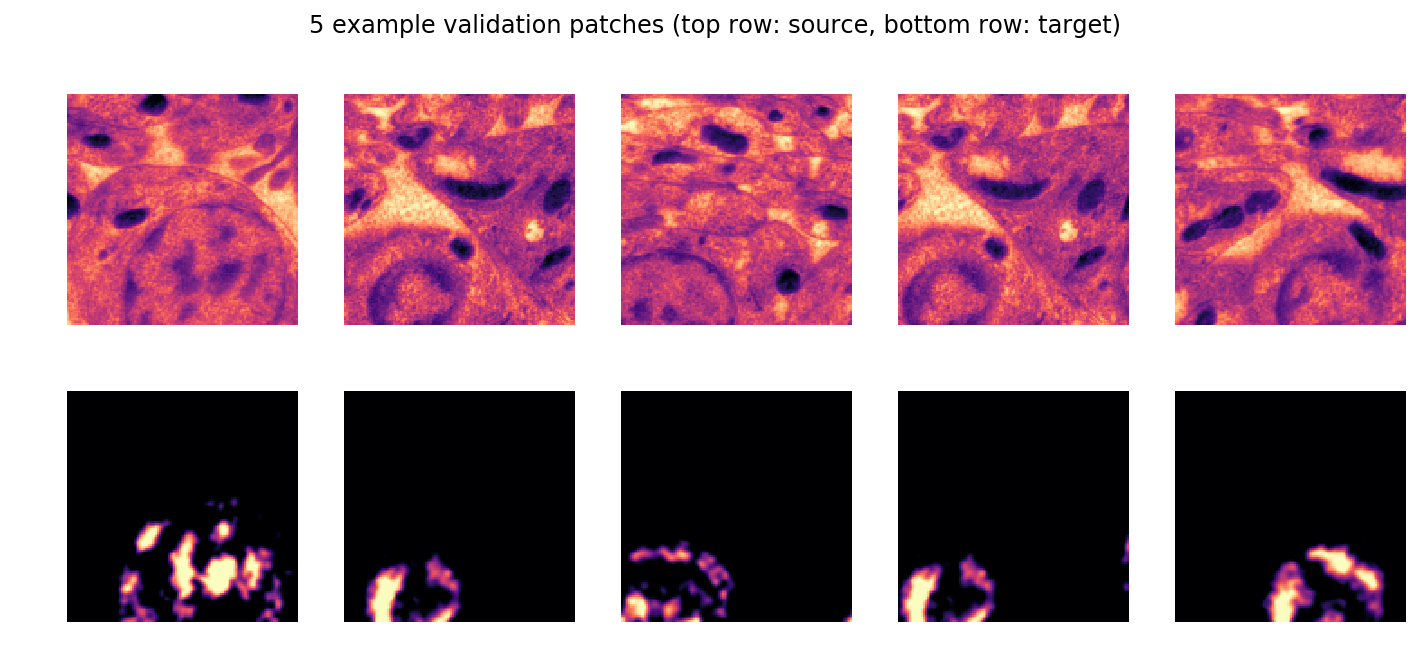

In [90]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');


In [91]:
config = Config(axes, n_channel_in, n_channel_out, unet_n_depth=3, train_batch_size=8, train_steps_per_epoch=20)
print(config)
vars(config)


Config(axes='ZYXC', n_channel_in=1, n_channel_out=1, n_dim=3, probabilistic=False, train_batch_size=8, train_checkpoint='weights_best.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=20, train_tensorboard=True, unet_input_shape=(None, None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=3, unet_n_first=32, unet_residual=True)


{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 100,
 'train_steps_per_epoch': 20,
 'train_learning_rate': 0.0004,
 'train_batch_size': 8,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

In [92]:




model.proj_params





ProjectionParameters(axis='Z', n_depth=4, n_filt=8, n_conv_per_depth=1, kern=(3, 3, 3), pool=(2, 2, 1))

In [93]:
model = ProjectionCARE(config, 'my_model', basedir='/home/s353960/programs/CSBDeep/')

In [94]:


model.proj_params



ProjectionParameters(axis='Z', n_depth=4, n_filt=8, n_conv_per_depth=1, kern=(3, 3, 3), pool=(1, 2, 2))

In [95]:

history = model.train(X,Y, validation_data=(X_val,Y_val))



Epoch 1/100
20/20 [==============================] - 3s 132ms/step - loss: 0.2450 - mse: 0.1092 - mae: 0.2450 - val_loss: 0.1343 - val_mse: 0.0519 - val_mae: 0.1343
Epoch 2/100
20/20 [==============================] - 1s 47ms/step - loss: 0.1049 - mse: 0.0402 - mae: 0.1049 - val_loss: 0.0887 - val_mse: 0.0349 - val_mae: 0.0887
Epoch 3/100
20/20 [==============================] - 1s 48ms/step - loss: 0.0802 - mse: 0.0315 - mae: 0.0802 - val_loss: 0.0770 - val_mse: 0.0330 - val_mae: 0.0770
Epoch 4/100
20/20 [==============================] - 1s 48ms/step - loss: 0.0711 - mse: 0.0299 - mae: 0.0711 - val_loss: 0.0698 - val_mse: 0.0305 - val_mae: 0.0698
Epoch 5/100
20/20 [==============================] - 1s 52ms/step - loss: 0.0669 - mse: 0.0289 - mae: 0.0669 - val_loss: 0.0656 - val_mse: 0.0299 - val_mae: 0.0656
Epoch 6/100
20/20 [==============================] - 1s 51ms/step - loss: 0.0603 - mse: 0.0264 - mae: 0.0603 - val_loss: 0.0658 - val_mse: 0.0306 - val_mae: 0.0658
Epoch 7/100
20/

Epoch 51/100
20/20 [==============================] - 1s 51ms/step - loss: 0.0156 - mse: 0.0014 - mae: 0.0156 - val_loss: 0.0181 - val_mse: 0.0029 - val_mae: 0.0181
Epoch 52/100
20/20 [==============================] - 1s 50ms/step - loss: 0.0150 - mse: 0.0011 - mae: 0.0150 - val_loss: 0.0153 - val_mse: 0.0028 - val_mae: 0.0153
Epoch 53/100
20/20 [==============================] - 1s 50ms/step - loss: 0.0159 - mse: 0.0013 - mae: 0.0159 - val_loss: 0.0149 - val_mse: 0.0026 - val_mae: 0.0149
Epoch 54/100
20/20 [==============================] - 1s 44ms/step - loss: 0.0139 - mse: 0.0010 - mae: 0.0139 - val_loss: 0.0162 - val_mse: 0.0027 - val_mae: 0.0162
Epoch 55/100
20/20 [==============================] - 1s 49ms/step - loss: 0.0137 - mse: 9.6219e-04 - mae: 0.0137 - val_loss: 0.0173 - val_mse: 0.0027 - val_mae: 0.0173
Epoch 56/100
20/20 [==============================] - 1s 49ms/step - loss: 0.0130 - mse: 8.6492e-04 - mae: 0.0130 - val_loss: 0.0170 - val_mse: 0.0027 - val_mae: 0.0170
Ep

20/20 [==============================] - 1s 45ms/step - loss: 0.0069 - mse: 2.8417e-04 - mae: 0.0069 - val_loss: 0.0128 - val_mse: 0.0023 - val_mae: 0.0128
Epoch 100/100
20/20 [==============================] - 1s 50ms/step - loss: 0.0057 - mse: 2.5945e-04 - mae: 0.0057 - val_loss: 0.0121 - val_mse: 0.0023 - val_mae: 0.0121

Loading network weights from 'weights_best.h5'.


['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


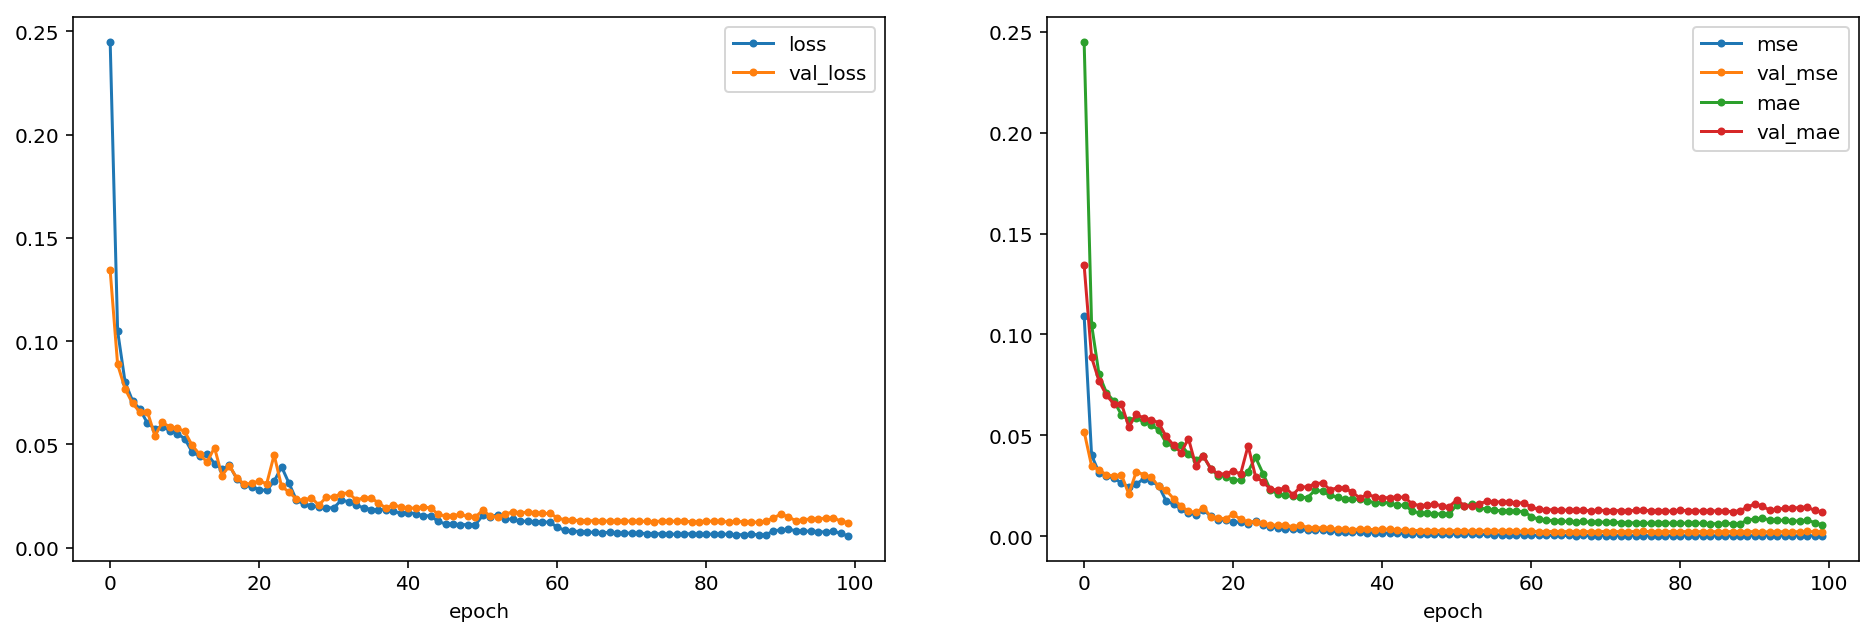

In [96]:


print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);



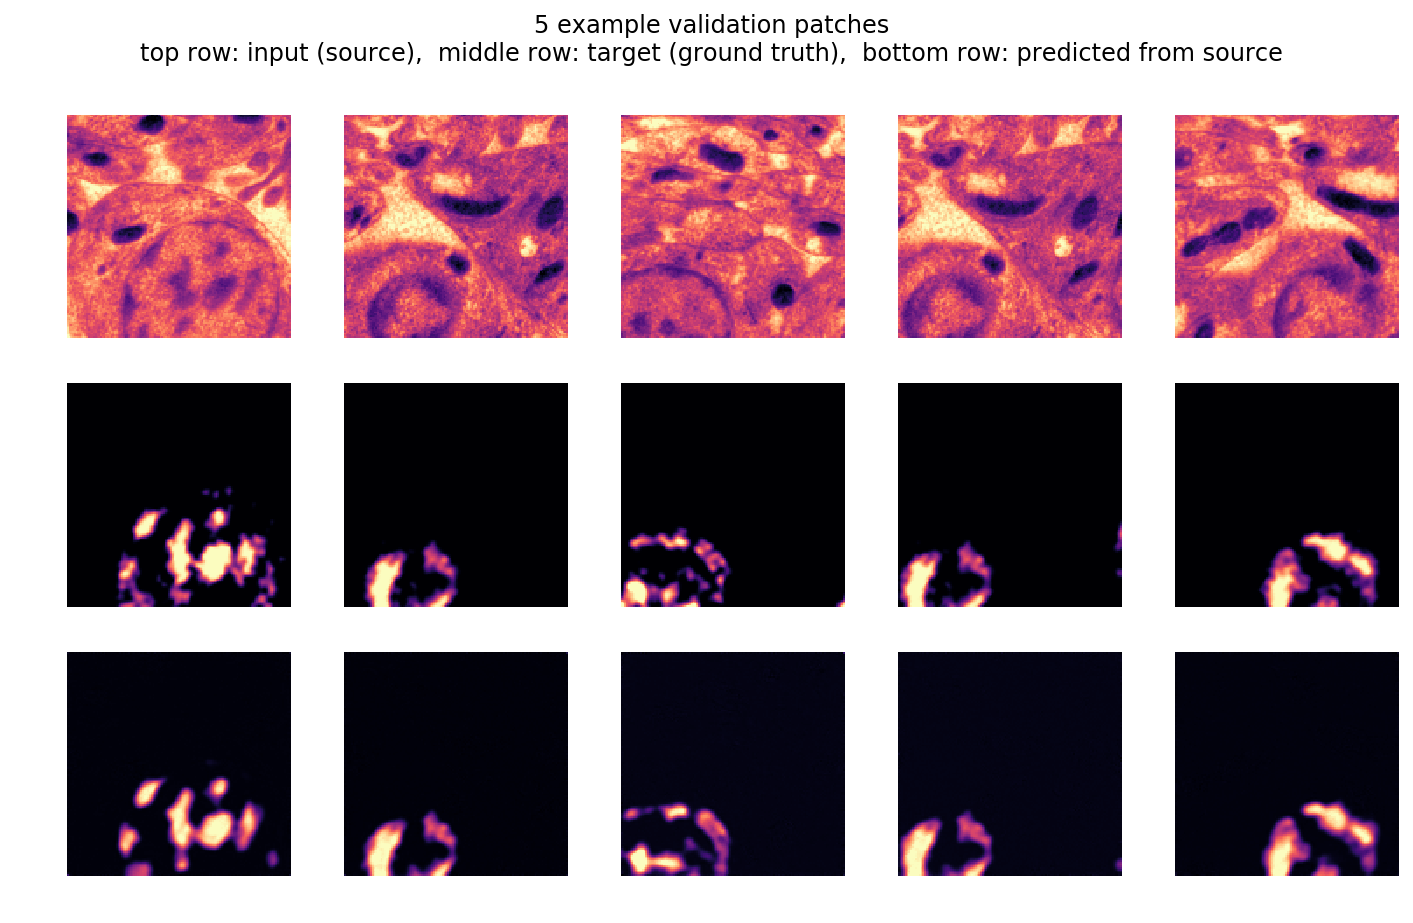

In [97]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');



In [98]:


model.export_TF()



INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmp08dmfu7s/model/saved_model.pb

Model exported in TensorFlow's SavedModel format:
/home/s353960/programs/CSBDeep/my_model/TF_SavedModel.zip
